In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo

def f(X):
    Y = (X - 1.5) ** 2 + 0.5
    print ('X= {}, Y = {}'.format(X, Y))
    return Y

搜索最小值的优化器

In [3]:
Xguess = 2.0 # set guess value
min_result = spo.minimize(f, Xguess, method = 'SLSQP', options = {'disp': True})
# 依次是（函数，猜测值，方法，是否显示详细信息）
print ('X = {}, Y = {}'.format(min_result.x, min_result.fun))

X= [ 2.], Y = [ 0.75]
X= [ 2.], Y = [ 0.75]
X= [ 2.00000001], Y = [ 0.75000001]
X= [ 0.99999999], Y = [ 0.75000001]
X= [ 1.5], Y = [ 0.5]
X= [ 1.5], Y = [ 0.5]
X= [ 1.50000001], Y = [ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
X = [ 1.5], Y = 0.5


X= [ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5], Y = [ 1.5   1.31  1.14  0.99  0.86  0.75  0.66  0.59  0.54  0.51  0.5   0.51
  0.54  0.59  0.66  0.75  0.86  0.99  1.14  1.31  1.5 ]


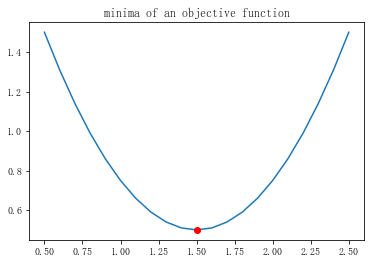

In [4]:
Xplot = np.linspace(0.5, 2.5, 21)
Yplot = f(Xplot)
plt.plot(Xplot, Yplot) 
plt.plot(min_result.x, min_result.fun, 'ro') # 在最小值处set 一个红色的圆
plt.title('minima of an objective function')
plt.show()

上面的方法仅限于找 连续的，单一最小值的，没有平线的minima，还有其他方法可以解决其他多种情况的minima，在介绍完这个之后再介绍

理解凸函数convex function的概念，任意取两点，两点所连成的直线上方没有graph region，组成的闭合区域。

如何通过优化器找到之前5中得到的拟合直线呢
首先优化器可以用来找最小值，那就想到了最小二乘法，来吧
我们要先找到把什么作为最小值，即方差，如下

In [5]:
def error(line, data):
    # line : tuple/list/array like(C0, C1), C0-slope, C1-intercept
    # data : 2D array where each row is a point(x, y)
    err = np.sum((data[:, 1] - (line[0] * data[:, 0] + line[1])) ** 2)
    return err

In [6]:
l_orig = np.float32([4, 2])
print ('original line: C0 = {}, C1 = {}'.format(l_orig[0],l_orig[1]))

original line: C0 = 4.0, C1 = 2.0


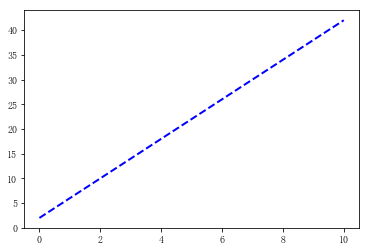

In [18]:
Xorig = np.linspace(0, 10, 21)
Yorig = l_orig[0] * Xorig + l_orig[1]
plt.plot(Xorig, Yorig, 'b--', linewidth = 2.0, label = 'original line')
plt.show()

In [25]:
noise_sigma = 3.0
noise = np.random.normal(0, noise_sigma, Yorig.shape)
data = np.asarray([Xorig, Yorig + noise]).T
plt.plot(data[:, 0], data[:, 1], 'go', label = 'Data points') 
# 如果加入plt.show，就无法在下面的图看到两个一起的效果了
# 加入噪音创作一条需要拟合的线

In [23]:
def fit_line(data, error_func): # data是加了noise的2D array
    l = np.float32([0, np.mean(data[:, 1])]) # slope = 0, intercept = mean y values
    
    x_ends = np.float32([-5, 5])
    plt.plot(x_ends, l[0] * x_ends + l[1], 'm--', linewidth = 2.0, label = 'initial line')
    #初始猜测线
    
    result = spo.minimize(error_func, l, args = (data,), method = 'SLSQP', options = {'disp':True}) # disp=display
    # args参数是指数据进入方式
    return result.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 236.00817616406948
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Fitted line: C0 = 4.157570673344823, C1 = 0.044936701076709634


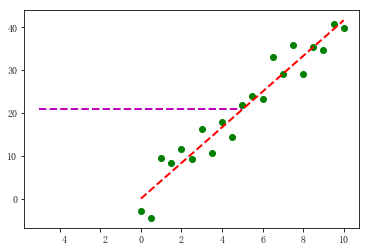

In [26]:
l_fit = fit_line(data, error)
print ('Fitted line: C0 = {}, C1 = {}'.format(l_fit[0], l_fit[1]))
plt.plot(data[:, 0], l_fit[0] * data[:, 0] + l_fit[1], 'r--', linewidth = 2.0)
plt.show()

复杂的多项式曲线拟合

In [27]:
def error_poly(C, data):
    # C : numpy.poly1d object，代表多项式系数
    # data ：2D array as point x,y
    err = np.sum((data[:, 1] - np.polyval(C, data[:, 0])) ** 2)
    return err

In [29]:
np.poly1d(np.ones(3 + 1, dtype = np.float32))

poly1d([ 1.,  1.,  1.,  1.], dtype=float32)

In [ ]:
def fit_poly(data, error_func, degree = 3):
    
    Cguess = np.poly1d(np.ones(degree + 1, dtype = np.float32)) # poly1d得到多项式序列，np.ones即都是1
    
    x = np.linspace(-5, 5, 21)
    plt.plot(x, np.polyval(Cguess, x), 'm--', linewidth = 2.0, label = 'initial guess')
    
    result = spo.minimize(error_func, Cguess, args = (data,), method = 'SLSQP', option = {'disp':True})
    return np.poly1d(result.x)

对于资产组合来讲，原理是一样的
a function to minimize ：- sharpe_ratio 参数是下面的X
a initial guess for X: 资产分配
call the optimizer

需要注意的两点是
range，资产分配范围为0-1，不限制范围可能会出现一个分配-1，另一个2的情况，所以我们要设置range给optimizer，这样也会变得更快
constraints，必须限制资产分配总和为1，True
